In [2]:
import ee

# Trigger the authentication flow.
# ee.Authenticate()

ee.Initialize(project='ee-arzaaan789')

In [3]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv("TGB_bat.csv", delimiter='\t')
df = df[df["occurrenceStatus"] == "PRESENT"]
df = df[df['year']>=2022]
# df['eventDate'] = df['eventDate'].str.replace('/','')
df['eventDate'] = pd.to_datetime(df['eventDate'], format='%Y-%m-%d', errors='coerce')
df = df[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
df = df.dropna().reset_index(drop=True)

In [4]:
import ee
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

# ee.Initialize()

# Your dataframe 'df' must have columns: decimalLongitude, decimalLatitude
# Example: df = pd.read_csv("Erinaceus europaeus.csv", delimiter='\t')

def create_aoi(lon, lat, box_size_km=1):
    """Create approx 1km x 1km square polygon around lon, lat."""
    half_side_deg = box_size_km / 111.32 / 2  # Rough approx degrees per km

    coords = [
        [lon - half_side_deg, lat - half_side_deg],
        [lon + half_side_deg, lat - half_side_deg],
        [lon + half_side_deg, lat + half_side_deg],
        [lon - half_side_deg, lat + half_side_deg],
        [lon - half_side_deg, lat - half_side_deg]
    ]
    return ee.Geometry.Polygon(coords)

def compute_all_indices(feature, start_date, end_date):
    """Compute spectral indices and LST for one EE Feature (with AOI geometry)."""
    aoi = feature.geometry()

    s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filterBounds(aoi)
          .filterDate(start_date, end_date)
          .sort('CLOUDY_PIXEL_PERCENTAGE')
          .first())
    s2 = ee.Image(s2).clip(aoi)

    blue = s2.select('B2')
    green = s2.select('B3')
    red = s2.select('B4')
    nir = s2.select('B8')
    swir = s2.select('B11')

    L = 0.5  # SAVI constant

    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    ndbi = swir.subtract(nir).divide(swir.add(nir)).rename('NDBI')
    savi = nir.subtract(red).divide(nir.add(red).add(L)).multiply(1 + L).rename('SAVI')
    mndwi = green.subtract(swir).divide(green.add(swir)).rename('MNDWI')
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')
    bsi = (red.add(blue).subtract(nir.add(swir))).divide(red.add(blue).add(nir).add(swir)).rename('BSI')
    ui = nir.subtract(swir).divide(nir.add(swir)).rename('UI')

    reducers = ee.Reducer.mean()
    scale_10m = 1000

    ndvi_mean = ndvi.reduceRegion(reducers, aoi, scale_10m).get('NDVI')
    ndwi_mean = ndwi.reduceRegion(reducers, aoi, scale_10m).get('NDWI')
    ndbi_mean = ndbi.reduceRegion(reducers, aoi, scale_10m).get('NDBI')
    savi_mean = savi.reduceRegion(reducers, aoi, scale_10m).get('SAVI')
    mndwi_mean = mndwi.reduceRegion(reducers, aoi, scale_10m).get('MNDWI')
    ndsi_mean = ndsi.reduceRegion(reducers, aoi, scale_10m).get('NDSI')
    bsi_mean = bsi.reduceRegion(reducers, aoi, scale_10m).get('BSI')
    ui_mean = ui.reduceRegion(reducers, aoi, scale_10m).get('UI')

    # MODIS LST dataset
    modis = (ee.ImageCollection("MODIS/061/MOD11A1")
             .filterBounds(aoi)
             .filterDate(start_date, end_date)
             .select('LST_Day_1km'))

    lst_mean_img = modis.mean().multiply(0.02).clip(aoi)

    lst_mean = lst_mean_img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=1000
    ).get('LST_Day_1km')

    return feature.set({
        'NDVI': ndvi_mean,
        'NDWI': ndwi_mean,
        'NDBI': ndbi_mean,
        'SAVI': savi_mean,
        'MNDWI': mndwi_mean,
        'NDSI': ndsi_mean,
        'BSI': bsi_mean,
        'UI': ui_mean,
        'LST': lst_mean
    })

# Split df into batches
batch_size = 50
batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

results_list = []

index_names = ['NDVI', 'NDWI', 'NDBI', 'SAVI', 'MNDWI', 'NDSI', 'BSI', 'UI', 'LST']

for batch in tqdm(batches, desc="Processing batches"):
    features = []
    batch_indices = []
    feature_metadata = {}

    for idx, row in batch.iterrows():
        
        aoi = create_aoi(row['decimalLongitude'], row['decimalLatitude'])
        feature = ee.Feature(aoi).set('index', idx)
        features.append(feature)
        batch_indices.append(idx)  # Save the original index
        
        event_date = row['eventDate']
        start_date = (event_date - timedelta(days=15)).strftime('%Y-%m-%d')
        end_date = (event_date + timedelta(days=15)).strftime('%Y-%m-%d')
        feature_metadata[idx] = (start_date, end_date)

    # Create a FeatureCollection from the list of features
    fc = ee.FeatureCollection(features)
    
    # Define wrapper for map to inject per-feature dates
    def map_with_dates(f):
        idx = f.get('index')
        # Use dictionary lookup to get dates for this feature
        date_dict = ee.Dictionary(ee.Dictionary(feature_metadata))
        dates = ee.List(date_dict.get(ee.Number(idx)))
        return compute_all_indices(f, dates.get(0), dates.get(1))

    try:
        result_fc = fc.map(map_with_dates)
        results = result_fc.getInfo()

        rows = []
        for f in results['features']:
            props = f['properties']
            rows.append(props)

    except Exception as e:
        print(f"Error processing batch starting at index {batch.index[0]}: {e}")
        # If there's an error, create placeholder rows with None
        rows = [{'index': i, **{name: None for name in index_names}} for i in batch_indices]

    batch_results_df = pd.DataFrame(rows).sort_values('index').reset_index(drop=True)
    results_list.append(batch_results_df)

# Concatenate all batches and sort by original index
all_results_df = pd.concat(results_list).sort_values('index').reset_index(drop=True)

# Merge with original df
df_final = pd.concat([df.reset_index(drop=True), all_results_df.drop(columns=['index'])], axis=1)

print(df_final.head())


Processing batches: 100%|██████████| 141/141 [12:18<00:00,  5.24s/it]

                     species  decimalLatitude  decimalLongitude  eventDate  \
0  Pipistrellus pipistrellus        52.619031         -0.834527 2022-06-22   
1  Pipistrellus pipistrellus        52.619031         -0.834527 2022-06-26   
2  Pipistrellus pipistrellus        52.619031         -0.834527 2022-06-28   
3  Pipistrellus pipistrellus        52.619031         -0.834527 2022-07-25   
4  Pipistrellus pipistrellus        52.619031         -0.834527 2022-06-23   

        BSI         LST     MNDWI      NDBI      NDSI      NDVI      NDWI  \
0 -0.787312  296.632402 -0.505106 -0.364924 -0.505106  0.816945 -0.734614   
1 -0.779564  297.862372 -0.575241 -0.290175 -0.575241  0.786288 -0.741630   
2 -0.779564  297.862372 -0.575241 -0.290175 -0.575241  0.786288 -0.741630   
3 -0.779564  303.103360 -0.575241 -0.290175 -0.575241  0.786288 -0.741630   
4 -0.787312  296.823268 -0.505106 -0.364924 -0.505106  0.816945 -0.734614   

       SAVI        UI  
0  1.225286  0.364924  
1  1.179296  0.29017

In [5]:
df_final.to_csv("tgb_bat_full_data.csv", index=False)
df = pd.read_csv("tgb_bat_full_data.csv")
df['eventDate'] = pd.to_datetime(df['eventDate'], format='%Y-%m-%d', errors='coerce')

df = df.dropna().reset_index(drop=True)

In [6]:
ceratopogonidae = pd.read_csv("Ceratopogonidae.csv", delimiter='\t')
ceratopogonidae = ceratopogonidae[ceratopogonidae["occurrenceStatus"] == "PRESENT"]
ceratopogonidae = ceratopogonidae[ceratopogonidae['year']>=2022]
ceratopogonidae['eventDate'] = pd.to_datetime(ceratopogonidae['eventDate'], format='%Y-%m-%d', errors='coerce')
ceratopogonidae = ceratopogonidae[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
ceratopogonidae = ceratopogonidae.dropna().reset_index(drop=True)

chironomidae = pd.read_csv("Chironomidae.csv", delimiter='\t')
chironomidae = chironomidae[chironomidae["occurrenceStatus"] == "PRESENT"]
chironomidae = chironomidae[chironomidae['year']>=2022]
chironomidae['eventDate'] = pd.to_datetime(chironomidae['eventDate'], format='%Y-%m-%d', errors='coerce')
chironomidae = chironomidae[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
chironomidae = chironomidae.dropna().reset_index(drop=True)

cats = pd.read_csv("cats.csv", delimiter='\t')
cats = cats[cats["occurrenceStatus"] == "PRESENT"]
cats = cats[cats['year']>=2022]
cats['eventDate'] = pd.to_datetime(cats['eventDate'], format='%Y-%m-%d', errors='coerce')
cats = cats[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
cats = cats.dropna().reset_index(drop=True)


wind_turbines = pd.read_excel("REPD_202407_WIND.xlsx")
wind_turbines = wind_turbines[wind_turbines['DEVSTATSHT']=='Operational']
wind_turbines = wind_turbines[['LAT','LNG']]
wind_turbines = wind_turbines.rename(columns={'LAT': 'decimalLatitude', 'LNG': 'decimalLongitude'})
wind_turbines = wind_turbines.dropna().reset_index(drop=True)

In [7]:
import numpy as np
from sklearn.neighbors import BallTree

# Convert lat/lon to radians for BallTree
bat_coords = np.deg2rad(df[['decimalLatitude', 'decimalLongitude']].values)
ceratopogonidae_coords = np.deg2rad(ceratopogonidae[['decimalLatitude', 'decimalLongitude']].values)
chironomidae_coords = np.deg2rad(chironomidae[['decimalLatitude', 'decimalLongitude']].values)
cats_coords = np.deg2rad(cats[['decimalLatitude', 'decimalLongitude']].values)
wind_turbines_coords = np.deg2rad(wind_turbines[['decimalLatitude', 'decimalLongitude']].values)

# Build BallTree using haversine metric
tree_ceratopogonidae = BallTree(ceratopogonidae_coords, metric='haversine')
tree_chironomidae = BallTree(chironomidae_coords, metric='haversine')
tree_cats = BallTree(cats_coords, metric='haversine')
tree_wind_turbines = BallTree(wind_turbines_coords, metric='haversine')

# Define search radius: 1 km in radians
earth_radius_km = 6371.0
radius = 1 / earth_radius_km  # 1 km in radians

# Initialize presence columns
df['ceratopogonidae_presence'] = 0
df['chironomidae_presence'] = 0
df['cats_presence'] = 0

# Iterate through each bat point with tqdm for progress tracking
for i in tqdm(range(len(df))):
    point = bat_coords[i].reshape(1, -1)
    event_month = df.loc[i, 'eventDate'].month
    event_year = df.loc[i, 'eventDate'].year

    # CERATOPOGONIDAE
    idxs = tree_ceratopogonidae.query_radius(point, r=radius)[0]
    for j in idxs:
        ceratopogonidae_date = ceratopogonidae.loc[j, 'eventDate']
        if ceratopogonidae_date.month == event_month and ceratopogonidae_date.year == event_year:
            df.at[i, 'ceratopogonidae_presence'] = 1
            break  # Found at least one match, no need to check further

    # CHIRONOMIDAE
    idxs = tree_chironomidae.query_radius(point, r=radius)[0]
    for j in idxs:
        chironomidae_date = chironomidae.loc[j, 'eventDate']
        if chironomidae_date.month == event_month and chironomidae_date.year == event_year:
            df.at[i, 'chironomidae_presence'] = 1
            break  # Found at least one match, no need to check further
            
    # CATS
    idxs = tree_cats.query_radius(point, r=radius)[0]
    for j in idxs:
        cats_date = cats.loc[j, 'eventDate']
        if cats_date.month == event_month and cats_date.year == event_year:
            df.at[i, 'cats_presence'] = 1
            break  # Found at least one match, no need to check further
        
indices = tree_wind_turbines.query_radius(bat_coords, r=radius)
df['wind_turbines_presence'] = [1 if len(neighbors) > 0 else 0 for neighbors in indices]

100%|██████████| 6908/6908 [00:00<00:00, 12003.54it/s]


In [8]:
import osmnx as ox
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from tqdm import tqdm

# Construct GeoDataFrame
df['geometry'] = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Define spatial tiling: 0.05 x 0.05 degrees
tile_size_lat = 0.009   # ~1 km in latitude degrees
tile_size_lon = 0.0157  # ~1 km in longitude degrees
padding_lat = 0.002  # ~200m latitude padding
padding_lon = 0.003  # ~200-300m longitude padding

gdf['tile_x'] = (gdf['decimalLongitude'] // tile_size_lon).astype(int)
gdf['tile_y'] = (gdf['decimalLatitude'] // tile_size_lat).astype(int)

# Group by tile
grouped = gdf.groupby(['tile_x', 'tile_y'])

# Store results
all_distances = []

for (tile_x, tile_y), group in tqdm(grouped, total=len(grouped)):
    west = tile_x * tile_size_lon - padding_lon
    south = tile_y * tile_size_lat - padding_lat
    east = (tile_x + 1) * tile_size_lon + padding_lon
    north = (tile_y + 1) * tile_size_lat + padding_lat
    bbox = (west, south, east, north)


    try:
        G = ox.graph_from_bbox(bbox, network_type='drive_service')
        if len(G.nodes) == 0:
            print(f"[EMPTY GRAPH] bbox: {bbox}, skipping...")
            all_distances.extend([np.nan] * len(group))
            continue

        G_proj = ox.project_graph(G)
        nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)
        points_proj = group.geometry.to_crs(nodes_proj.crs)

        for point_proj in points_proj:
            try:
                u, v, k = ox.distance.nearest_edges(G_proj, [point_proj.x], [point_proj.y])[0]
                edge_geom = edges_proj.loc[(u, v, k)]['geometry']
                distance = point_proj.distance(edge_geom)
                all_distances.append(distance)
            except Exception as e:
                print(f"  [Point ERROR] {e}")
                all_distances.append(np.nan)

    except Exception as e:
        print(f"[TILE ERROR] {e} — bbox: {bbox}")
        all_distances.extend([np.nan] * len(group))


# Store back in original DataFrame order
gdf['distance_to_road'] = all_distances

  0%|          | 1/1794 [00:00<16:08,  1.85it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-7.3191999999999995), np.float64(57.22899999999999), np.float64(-7.297499999999999), np.float64(57.242))


  0%|          | 3/1794 [00:01<13:11,  2.26it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-6.3458), np.float64(49.93899999999999), np.float64(-6.3241), np.float64(49.952))


  2%|▏         | 32/1794 [00:14<06:07,  4.80it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.697299999999999), np.float64(51.882999999999996), np.float64(-4.675599999999999), np.float64(51.896))


  3%|▎         | 46/1794 [00:18<08:43,  3.34it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.2577), np.float64(51.62199999999999), np.float64(-4.236), np.float64(51.635))


  3%|▎         | 51/1794 [00:21<13:48,  2.11it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-4.1792), np.float64(52.971999999999994), np.float64(-4.1575), np.float64(52.985))


  4%|▎         | 64/1794 [00:25<10:27,  2.76it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.0379), np.float64(53.160999999999994), np.float64(-4.0161999999999995), np.float64(53.174))


  4%|▍         | 69/1794 [00:27<08:14,  3.49it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.0222), np.float64(52.89099999999999), np.float64(-4.0005), np.float64(52.903999999999996))


  5%|▍         | 82/1794 [00:32<10:32,  2.71it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.8495), np.float64(52.440999999999995), np.float64(-3.8277999999999994), np.float64(52.454))


  5%|▍         | 84/1794 [00:33<09:33,  2.98it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.8337999999999997), np.float64(52.080999999999996), np.float64(-3.8120999999999996), np.float64(52.094))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-3.8337999999999997), np.float64(52.17099999999999), np.float64(-3.8120999999999996), np.float64(52.184))


  5%|▍         | 87/1794 [00:33<06:44,  4.22it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.8181), np.float64(51.81099999999999), np.float64(-3.7963999999999998), np.float64(51.824))


  6%|▌         | 104/1794 [00:40<13:02,  2.16it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.5198), np.float64(54.42999999999999), np.float64(-3.4980999999999995), np.float64(54.443))


  6%|▋         | 114/1794 [00:46<16:42,  1.68it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.3941999999999997), np.float64(52.062999999999995), np.float64(-3.3724999999999996), np.float64(52.076))


  7%|▋         | 121/1794 [00:48<07:33,  3.69it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.3785), np.float64(56.175999999999995), np.float64(-3.3568), np.float64(56.189))


  7%|▋         | 132/1794 [00:52<06:41,  4.14it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.2843), np.float64(53.169999999999995), np.float64(-3.2625999999999995), np.float64(53.183))


  8%|▊         | 136/1794 [00:53<08:09,  3.39it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.2529), np.float64(51.81999999999999), np.float64(-3.2311999999999994), np.float64(51.833))
[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.2371999999999996), np.float64(51.459999999999994), np.float64(-3.2154999999999996), np.float64(51.473))


 10%|▉         | 171/1794 [01:13<16:44,  1.62it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.0802), np.float64(53.583999999999996), np.float64(-3.0584999999999996), np.float64(53.597))


 13%|█▎        | 227/1794 [01:56<16:11,  1.61it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.8918), np.float64(53.99799999999999), np.float64(-2.8700999999999994), np.float64(54.010999999999996))


 13%|█▎        | 236/1794 [02:04<15:54,  1.63it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.8604), np.float64(53.32299999999999), np.float64(-2.8387), np.float64(53.336))


 19%|█▉        | 344/1794 [03:21<14:34,  1.66it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.6719999999999997), np.float64(51.76599999999999), np.float64(-2.6502999999999997), np.float64(51.778999999999996))


 22%|██▏       | 387/1794 [03:57<12:50,  1.83it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5778), np.float64(55.266999999999996), np.float64(-2.5561), np.float64(55.28))


 22%|██▏       | 397/1794 [04:02<08:58,  2.59it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5621), np.float64(55.239999999999995), np.float64(-2.5403999999999995), np.float64(55.253))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5621), np.float64(55.248999999999995), np.float64(-2.5403999999999995), np.float64(55.262))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5621), np.float64(55.285), np.float64(-2.5403999999999995), np.float64(55.297999999999995))


 23%|██▎       | 407/1794 [04:07<09:35,  2.41it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.239999999999995), np.float64(-2.5246999999999997), np.float64(55.253))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.248999999999995), np.float64(-2.5246999999999997), np.float64(55.262))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.266999999999996), np.float64(-2.5246999999999997), np.float64(55.28))


 23%|██▎       | 409/1794 [04:07<06:34,  3.51it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.275999999999996), np.float64(-2.5246999999999997), np.float64(55.289))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.285), np.float64(-2.5246999999999997), np.float64(55.297999999999995))


 24%|██▎       | 426/1794 [04:15<07:24,  3.08it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5149999999999997), np.float64(55.266999999999996), np.float64(-2.4932999999999996), np.float64(55.28))


 24%|██▍       | 432/1794 [04:19<10:59,  2.06it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.4993), np.float64(55.275999999999996), np.float64(-2.4776), np.float64(55.289))


 26%|██▌       | 459/1794 [04:34<08:34,  2.59it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.3737), np.float64(52.37799999999999), np.float64(-2.352), np.float64(52.391))


 26%|██▌       | 462/1794 [04:36<13:12,  1.68it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.3737), np.float64(55.01499999999999), np.float64(-2.352), np.float64(55.028))


 27%|██▋       | 477/1794 [04:45<09:34,  2.29it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.3266), np.float64(52.971999999999994), np.float64(-2.3048999999999995), np.float64(52.985))


 30%|███       | 545/1794 [05:42<14:04,  1.48it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.1853), np.float64(50.730999999999995), np.float64(-2.1635999999999997), np.float64(50.744))


 31%|███       | 554/1794 [05:47<08:03,  2.56it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.1696), np.float64(50.730999999999995), np.float64(-2.1479), np.float64(50.744))


 32%|███▏      | 572/1794 [06:02<10:23,  1.96it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.1382), np.float64(50.712999999999994), np.float64(-2.1165), np.float64(50.726))


 32%|███▏      | 579/1794 [06:09<14:38,  1.38it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.1382), np.float64(53.99799999999999), np.float64(-2.1165), np.float64(54.010999999999996))


 32%|███▏      | 582/1794 [06:10<09:23,  2.15it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.1225), np.float64(50.721999999999994), np.float64(-2.1007999999999996), np.float64(50.735))


 36%|███▌      | 645/1794 [07:04<21:31,  1.12s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.0126), np.float64(52.76499999999999), np.float64(-1.9909), np.float64(52.778))


 39%|███▉      | 699/1794 [07:36<10:24,  1.75it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.8555999999999997), np.float64(51.01899999999999), np.float64(-1.8338999999999999), np.float64(51.032))


 47%|████▋     | 852/1794 [09:31<05:07,  3.07it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.3531999999999997), np.float64(52.87299999999999), np.float64(-1.3315), np.float64(52.885999999999996))


 51%|█████     | 918/1794 [10:14<09:36,  1.52it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.2589999999999997), np.float64(54.61899999999999), np.float64(-1.2373), np.float64(54.632))


 52%|█████▏    | 928/1794 [10:20<08:40,  1.66it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.2275999999999998), np.float64(52.68399999999999), np.float64(-1.2059), np.float64(52.696999999999996))


 52%|█████▏    | 935/1794 [10:24<09:03,  1.58it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.2118999999999998), np.float64(53.32299999999999), np.float64(-1.1902), np.float64(53.336))


 53%|█████▎    | 951/1794 [10:39<15:49,  1.13s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.1804999999999999), np.float64(51.18099999999999), np.float64(-1.1588), np.float64(51.193999999999996))


 54%|█████▍    | 965/1794 [10:53<12:23,  1.11it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.1647999999999998), np.float64(51.81099999999999), np.float64(-1.1431), np.float64(51.824))


 56%|█████▋    | 1012/1794 [11:31<07:42,  1.69it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.1019999999999999), np.float64(53.151999999999994), np.float64(-1.0803), np.float64(53.165))


 58%|█████▊    | 1038/1794 [11:52<04:44,  2.66it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.0548999999999997), np.float64(51.702999999999996), np.float64(-1.0332000000000001), np.float64(51.716))


 60%|█████▉    | 1069/1794 [12:11<04:05,  2.95it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.9920999999999999), np.float64(53.160999999999994), np.float64(-0.9703999999999999), np.float64(53.174))


 60%|█████▉    | 1074/1794 [12:15<09:38,  1.24it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.9763999999999999), np.float64(54.501999999999995), np.float64(-0.9546999999999999), np.float64(54.515))


 63%|██████▎   | 1139/1794 [13:16<05:33,  1.96it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.8193999999999999), np.float64(52.611999999999995), np.float64(-0.7977), np.float64(52.625))


 65%|██████▍   | 1158/1794 [13:30<05:48,  1.83it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7879999999999999), np.float64(54.312999999999995), np.float64(-0.7663), np.float64(54.326))


 65%|██████▌   | 1168/1794 [13:40<08:47,  1.19it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7723), np.float64(54.312999999999995), np.float64(-0.7505999999999999), np.float64(54.326))


 65%|██████▌   | 1171/1794 [13:42<05:48,  1.79it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7565999999999999), np.float64(51.03699999999999), np.float64(-0.7348999999999999), np.float64(51.05))


 66%|██████▌   | 1179/1794 [13:50<08:07,  1.26it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.7565999999999999), np.float64(54.321999999999996), np.float64(-0.7348999999999999), np.float64(54.335))


 66%|██████▌   | 1188/1794 [13:56<03:08,  3.21it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.7408999999999999), np.float64(53.224), np.float64(-0.7192), np.float64(53.237))
[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7408999999999999), np.float64(54.321999999999996), np.float64(-0.7192), np.float64(54.335))
[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.7408999999999999), np.float64(54.330999999999996), np.float64(-0.7192), np.float64(54.344))
[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7408999999999999), np.float64(54.339999999999996), np.float64(-0.7192), np.float64(54.353))


 67%|██████▋   | 1197/1794 [13:58<01:58,  5.04it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-0.7252), np.float64(54.330999999999996), np.float64(-0.7034999999999999), np.float64(54.344))
[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-0.7252), np.float64(54.349), np.float64(-0.7034999999999999), np.float64(54.362))


 67%|██████▋   | 1209/1794 [14:02<05:00,  1.95it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7094999999999999), np.float64(54.36699999999999), np.float64(-0.6878), np.float64(54.379999999999995))


 68%|██████▊   | 1220/1794 [14:07<04:12,  2.28it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.6938), np.float64(53.66499999999999), np.float64(-0.6720999999999999), np.float64(53.678))


 69%|██████▊   | 1230/1794 [14:11<03:49,  2.45it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-0.6780999999999999), np.float64(54.25899999999999), np.float64(-0.6564), np.float64(54.272))


 70%|██████▉   | 1250/1794 [14:20<05:25,  1.67it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.6466999999999999), np.float64(54.276999999999994), np.float64(-0.6249999999999999), np.float64(54.29))


 70%|███████   | 1259/1794 [14:24<04:55,  1.81it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.6309999999999999), np.float64(54.276999999999994), np.float64(-0.6093), np.float64(54.29))


 71%|███████   | 1268/1794 [14:32<07:59,  1.10it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.5995999999999999), np.float64(51.80199999999999), np.float64(-0.5779), np.float64(51.815))


 72%|███████▏  | 1284/1794 [14:44<04:45,  1.79it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.5525), np.float64(54.276999999999994), np.float64(-0.5307999999999999), np.float64(54.29))
[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.5525), np.float64(54.330999999999996), np.float64(-0.5307999999999999), np.float64(54.344))


 73%|███████▎  | 1313/1794 [14:59<04:16,  1.87it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.37979999999999997), np.float64(50.964999999999996), np.float64(-0.3581), np.float64(50.978))


 75%|███████▍  | 1340/1794 [15:14<03:01,  2.50it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.3327), np.float64(52.38699999999999), np.float64(-0.31099999999999994), np.float64(52.4))


 76%|███████▌  | 1360/1794 [15:26<02:23,  3.03it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.28559999999999997), np.float64(51.44199999999999), np.float64(-0.26389999999999997), np.float64(51.455))


 77%|███████▋  | 1383/1794 [15:42<03:12,  2.13it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.2542), np.float64(52.260999999999996), np.float64(-0.23249999999999998), np.float64(52.274))


 78%|███████▊  | 1394/1794 [15:48<03:09,  2.11it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.2385), np.float64(52.38699999999999), np.float64(-0.2168), np.float64(52.4))


 81%|████████  | 1448/1794 [16:45<07:46,  1.35s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.14429999999999998), np.float64(52.36899999999999), np.float64(-0.12259999999999999), np.float64(52.382))


 84%|████████▎ | 1500/1794 [17:43<04:45,  1.03it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.0501), np.float64(52.584999999999994), np.float64(-0.028399999999999998), np.float64(52.598))


 85%|████████▌ | 1527/1794 [18:11<02:42,  1.64it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.003), np.float64(52.404999999999994), np.float64(0.018699999999999998), np.float64(52.418))


 87%|████████▋ | 1561/1794 [18:41<02:30,  1.54it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.05979999999999999), np.float64(52.404999999999994), np.float64(0.08149999999999999), np.float64(52.418))


 89%|████████▉ | 1595/1794 [19:03<02:10,  1.53it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.1069), np.float64(52.297), np.float64(0.1286), np.float64(52.309999999999995))


 93%|█████████▎| 1666/1794 [19:47<00:56,  2.25it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(0.3581), np.float64(51.06399999999999), np.float64(0.37979999999999997), np.float64(51.077))


 93%|█████████▎| 1671/1794 [19:50<00:59,  2.05it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.3581), np.float64(52.32399999999999), np.float64(0.37979999999999997), np.float64(52.336999999999996))


 94%|█████████▍| 1683/1794 [19:58<01:20,  1.37it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.40519999999999995), np.float64(52.16199999999999), np.float64(0.42689999999999995), np.float64(52.175))


 94%|█████████▍| 1685/1794 [19:58<00:58,  1.86it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.40519999999999995), np.float64(52.288), np.float64(0.42689999999999995), np.float64(52.301))


 94%|█████████▍| 1687/1794 [20:00<00:56,  1.88it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(0.42089999999999994), np.float64(51.96399999999999), np.float64(0.4426), np.float64(51.977))


 95%|█████████▍| 1701/1794 [20:13<01:03,  1.45it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.46799999999999997), np.float64(52.827999999999996), np.float64(0.48969999999999997), np.float64(52.841))


 96%|█████████▋| 1731/1794 [20:28<00:43,  1.46it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.6249999999999999), np.float64(50.919999999999995), np.float64(0.6466999999999999), np.float64(50.933))


 97%|█████████▋| 1745/1794 [20:33<00:19,  2.54it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.7348999999999999), np.float64(51.837999999999994), np.float64(0.7565999999999999), np.float64(51.851))


100%|██████████| 1794/1794 [21:13<00:00,  1.41it/s]


In [9]:
gdf['near_road'] = np.where(gdf['distance_to_road'] <= 500, 1, 0)        

In [10]:
gdf=gdf.drop(['tile_x', 'tile_y', 'geometry', 'distance_to_road'], axis=1)

In [11]:
from pyproj import Transformer
from rasterio.windows import Window
import rasterio
from collections import Counter
import numpy as np


land_cover_map = {
    1: "Deciduous woodland",
    2: "Coniferous woodland",
    3: "Arable",
    4: "Improved grassland",
    5: "Neutral grassland",
    6: "Calcareous grassland",
    7: "Acid grassland",
    8: "Fen",
    9: "Heather",
    10: "Heather grassland",
    11: "Bog",
    12: "Inland rock",
    13: "Saltwater",
    14: "Freshwater",
    15: "Supralittoral rock",
    16: "Supralittoral sediment",
    17: "Littoral rock",
    18: "Littoral sediment",
    19: "Saltmarsh",
    20: "Urban",
    21: "Suburban"
}

# Batch coordinate transformation
transformer_ni = Transformer.from_crs("EPSG:4326", "EPSG:29903", always_xy=True)
transformer_gb = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

coords = list(zip(gdf['decimalLongitude'], gdf['decimalLatitude']))
gdf['easting_ni'], gdf['northing_ni'] = zip(*transformer_ni.itransform(coords))
gdf['easting_gb'], gdf['northing_gb'] = zip(*transformer_gb.itransform(coords))

# Raster processing optimization
gb_raster = 'gblcm2023_10m.tif'
n_ireland_raster = 'nilcm2023_10m.tif'


def get_land_cover_class_1km(row):
    try:
        window_size_pixels = 100  # 1 km / 10m resolution

        # Open GB raster and read 1km x 1km window
        with rasterio.open(gb_raster) as src:
            row_idx, col_idx = src.index(row['easting_gb'], row['northing_gb'])

            # Calculate window bounds, making sure not to go out of raster bounds
            row_start = max(row_idx - window_size_pixels // 2, 0)
            col_start = max(col_idx - window_size_pixels // 2, 0)

            # Adjust window size if near edges
            height = min(window_size_pixels, src.height - row_start)
            width = min(window_size_pixels, src.width - col_start)

            window = Window(col_start, row_start, width, height)
            data = src.read(1, window=window)

            # If all zero (or no data), fallback to NI raster
            if np.all(data == 0):
                with rasterio.open(n_ireland_raster) as src_ni:
                    row_idx_ni, col_idx_ni = src_ni.index(row['easting_ni'], row['northing_ni'])

                    row_start_ni = max(row_idx_ni - window_size_pixels // 2, 0)
                    col_start_ni = max(col_idx_ni - window_size_pixels // 2, 0)

                    height_ni = min(window_size_pixels, src_ni.height - row_start_ni)
                    width_ni = min(window_size_pixels, src_ni.width - col_start_ni)

                    window_ni = Window(col_start_ni, row_start_ni, width_ni, height_ni)
                    data_ni = src_ni.read(1, window=window_ni)

                    data = data_ni

            # Find the most common class (mode) ignoring zeros (assuming 0 means no data)
            unique, counts = np.unique(data[data != 0], return_counts=True)
            if len(counts) == 0:
                return "Unknown"

            mode_class = unique[np.argmax(counts)]
            return land_cover_map.get(mode_class, "Unknown")

    except Exception as e:
        print(f"Error processing row: {e}")
        return "Unknown"


tqdm.pandas()
gdf['Land_cover'] = gdf.progress_apply(get_land_cover_class_1km, axis=1)


100%|██████████| 6908/6908 [03:35<00:00, 32.04it/s]


In [ ]:
gdf = gdf.dropna()
gdf=gdf.drop(['easting_ni', 'northing_ni', 'easting_gb', 'northing_gb'],axis=1)
# Remove where Land_cover is Unknown
gdf = gdf[gdf['Land_cover'] != "Unknown"].reset_index(drop=True)
gdf.to_csv("tgb_bat_final_data.csv", index=False)

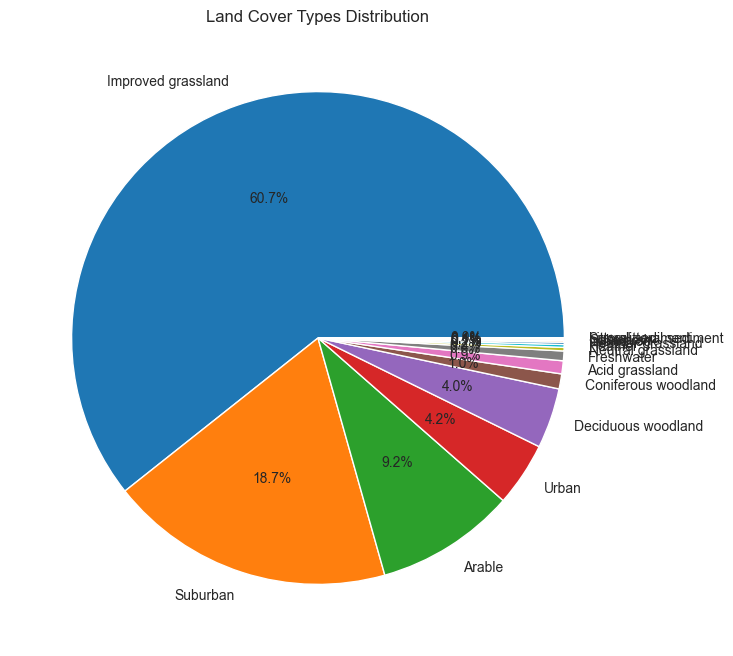

In [1]:
import pandas as pd
df = pd.read_csv("tgb_bat_final_data.csv")

import matplotlib.pyplot as plt
# df = df[df['probability'] > 0.6]

# #do inverse of one-hot encoding for columns starting with "Land_cover_"
# land_cover_cols = [col for col in df.columns if col.startswith('Land_cover_')]
# def get_land_cover(row):
#     for col in land_cover_cols:
#         if row[col] == 1:
#             return col.replace('Land_cover_', '')
#     return 'Unknown'
# df['Land_cover'] = df.apply(get_land_cover, axis=1)
# # df = df[['decimalLatitude', 'decimalLongitude', 'probability', 'Land_cover']]

# pie chart of land cover types
land_cover_counts = df['Land_cover'].value_counts()
land_cover_counts.plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Land Cover Types Distribution')
plt.ylabel('')
plt.show()
